# Clustering Standard Errors in AB Tests

*What to do when the unit of observation differs from the unit of randomization*

A/B tests are the golden standard of causal inference because they allow us to make valid causal statements under minimal assumptions, thanks to **randomization**. In fact, by randomly assigning a **treatment** (a drug, ad, product, ...), we are able to compare the **outcome** of interest (a disease, firm revenue, customer satisfaction, ...) across **subjects** (patients, users, customers, ...) and attribute the average difference in outcomes to the causal effect of the treatment.

Sometimes it happens that the **unit of treatment assignment differs from the unit of observation**. In other words, we do not take the decision on whether to treat every single observation independently, but rather in groups. For example, we might decide to treat all customers in a certain region while observing outcomes at the customer level, or treat all articles of a certain brand, while observing outcomes at the article level. Usually this happens because of practical constraints. In the first example, the so-called *geo-experiments*, it happens because we are unable to track users because of cookie deprecations. 

When this happens, treatment effects are **not independent** across observations anymore. In fact, if a customer in a region is treated, also other customers in the same region will be treated. If an article of a brand is not treated, also other articles of the same brand will not be treated. When doing inference, we have to take this dependence into account: standard errors, confidence intervals, and p-values should be adjusted. In this article, we will explore how to do that using **cluster-robust standard errors**.

## Customers, Orders, and Standard Errors

Imagine you were an online platform and you are intrested in increasing sales. You just had a great idea: showing a **carousel of related articles** at checkout to incentivize customer to add other articles to their basket. In order to understand whether the carousel increases sales, you decide to AB test it. In principle, you coud just decide for every order whether to display the carousel or not, at random. However, this would give customers an inconsistent experience, potentially harming the business. Therefore, you decide to randomize the treatment assignment, the carousel, at the customer level. To treated customers, you show the carousel on every order, and to control customer you never show the carousel.

I import the data-generating process (dgp) from [src.dgp_collection](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp_collection.py) and the plotting theme from [src.theme](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/theme.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from numpy.linalg import inv
import pandas as pd

from src.theme import *
from src.dgp_collection import dgp_carousel

We generate simulated data for `3000` orders, from `100` customers. For each order, we observe the `order_id` which is also the dataset index, the `customer_id` of the customer who placed the order, whether the `carousel` was displayed at checkout - the treatment - and the order `revenue` - the outcome of interest.

In [3]:
n = 3000
dgp = dgp_carousel(n=n, w="carousel", y=["revenue"])
df = dgp.generate_data()
df.head()

,order_id,customer_id,carousel,revenue
0,1755,58,1,52.61
1,527,17,0,44.19
2,595,19,0,73.04
3,2027,67,0,65.54
4,366,12,0,62.57


Since treatment was randomized, we can estimate the **average treatment effect** comparing the average revenue of treated orders against the average revenue of control (not treated) orders. Randomization ensures that treated and untreated orders are comparable on average, except for the treatment itself, and therefore we can attribute any observable difference to the causal effect of the treatment. We can estimate the difference-in-means using linear regression, by regressing `revenue` on the `carousel` dummy variable. The reported OLS coefficient is the estimated average treatment effect. 

In [4]:
import statsmodels.formula.api as smf
smf.ols("revenue ~ carousel", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,61.6361,0.382,161.281,0.000,60.887,62.385
carousel,-1.6292,0.576,-2.828,0.005,-2.759,-0.500


It seems that including the `carousel` decreased `revenue` by `-1.63€` per order. The treatment effect seems to be statistically significant at the *1%* level since the reported p-value is `0.005`. However, this is **not a standard AB test**, since we didn't randomize each single order, but rather customers. Two orders placed by the same customer couldn't go to different treatment groups. Because of this, our treatment effects across observations are correlated, while we computed our standard errors assuming that they are independent. 

Are the reported **standard errors correct**? How can we "check" it and what can we do about it?

## Standard Errors

Which standard errors are "correct"?

The answer to this question depends on what we consider **random** and what we consider **fixed**. In the frequentist sense, standard errors measure uncertainty across "states of the world" or "parallel universes" that would have happened if we had seen a different realization of the random part of the data-generating process.

In this particular case, there is one variable that is uncontroversially random: the treatment **assignment**, in fact, we randomized it ourselves. Not only that, we also know *how* it is random: each customer had a 50% chance of seeing the `carousel` and a 50% chance of not seeing it.

Therefore, we would like our estimated standard errors to measure the variation in estimated treatment effects across alternative treatment assignments. This is normally an **abstract** concept since we cannot re-run the exact same experiment. However, we can in our case, since we are in a simulated environment.

The `DGP` class has a `evaluate_f_redrawing_assignment` function that allows us to evaluate a function of the data *f(X)* by re-sampling the data drawing different treatment assignments. The function we want to evaluate is our linear regression for treatment effect estimation. 

In [5]:
def estimate_treatment_effect(df):
    reg = smf.ols("revenue ~ carousel", data=df).fit()
    return reg.params["carousel"], reg.bse["carousel"]

We repeat the treatment effect estimation over *1000* different random assignments. 

In [6]:
n_draws = 1_000
ols_coeff = dgp.evaluate_f_redrawing_assignment(f=estimate_treatment_effect, n_draws=n_draws)

In the figure below, we plot the **distribution** of the estimated OLS coefficients and standard errors. In the plot of the estimated standard errors (on the right), we also report a vertical line with the standard deviation of the estimated coefficients across simulations (on the left).

In [7]:
def plot_coefficients(coeffs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Estimates
    coeffs_est = list(zip(*coeffs))[0]
    sns.histplot(coeffs_est, color="C1", ax=ax1)
    ax1.set(title=f"Distribution of estimated coefficients")
    ax1.legend([f"Average: {np.mean(coeffs_est):.3f}\nStd. Dev: {np.std(coeffs_est):.3f}"]);

    # Standsed error
    coeffs_std = list(zip(*coeffs))[1]
    sns.histplot(coeffs_std, color="C0", ax=ax2)
    ax2.set(title=f"Distribution of estimated std. errors")
    ax2.legend([f"Average: {np.mean(coeffs_std):.3f}\nStd. Dev: {np.std(coeffs_std):.3f}"]);
    ax2.axvline(np.std(coeffs_est), lw=2, ls="--", c="C1")

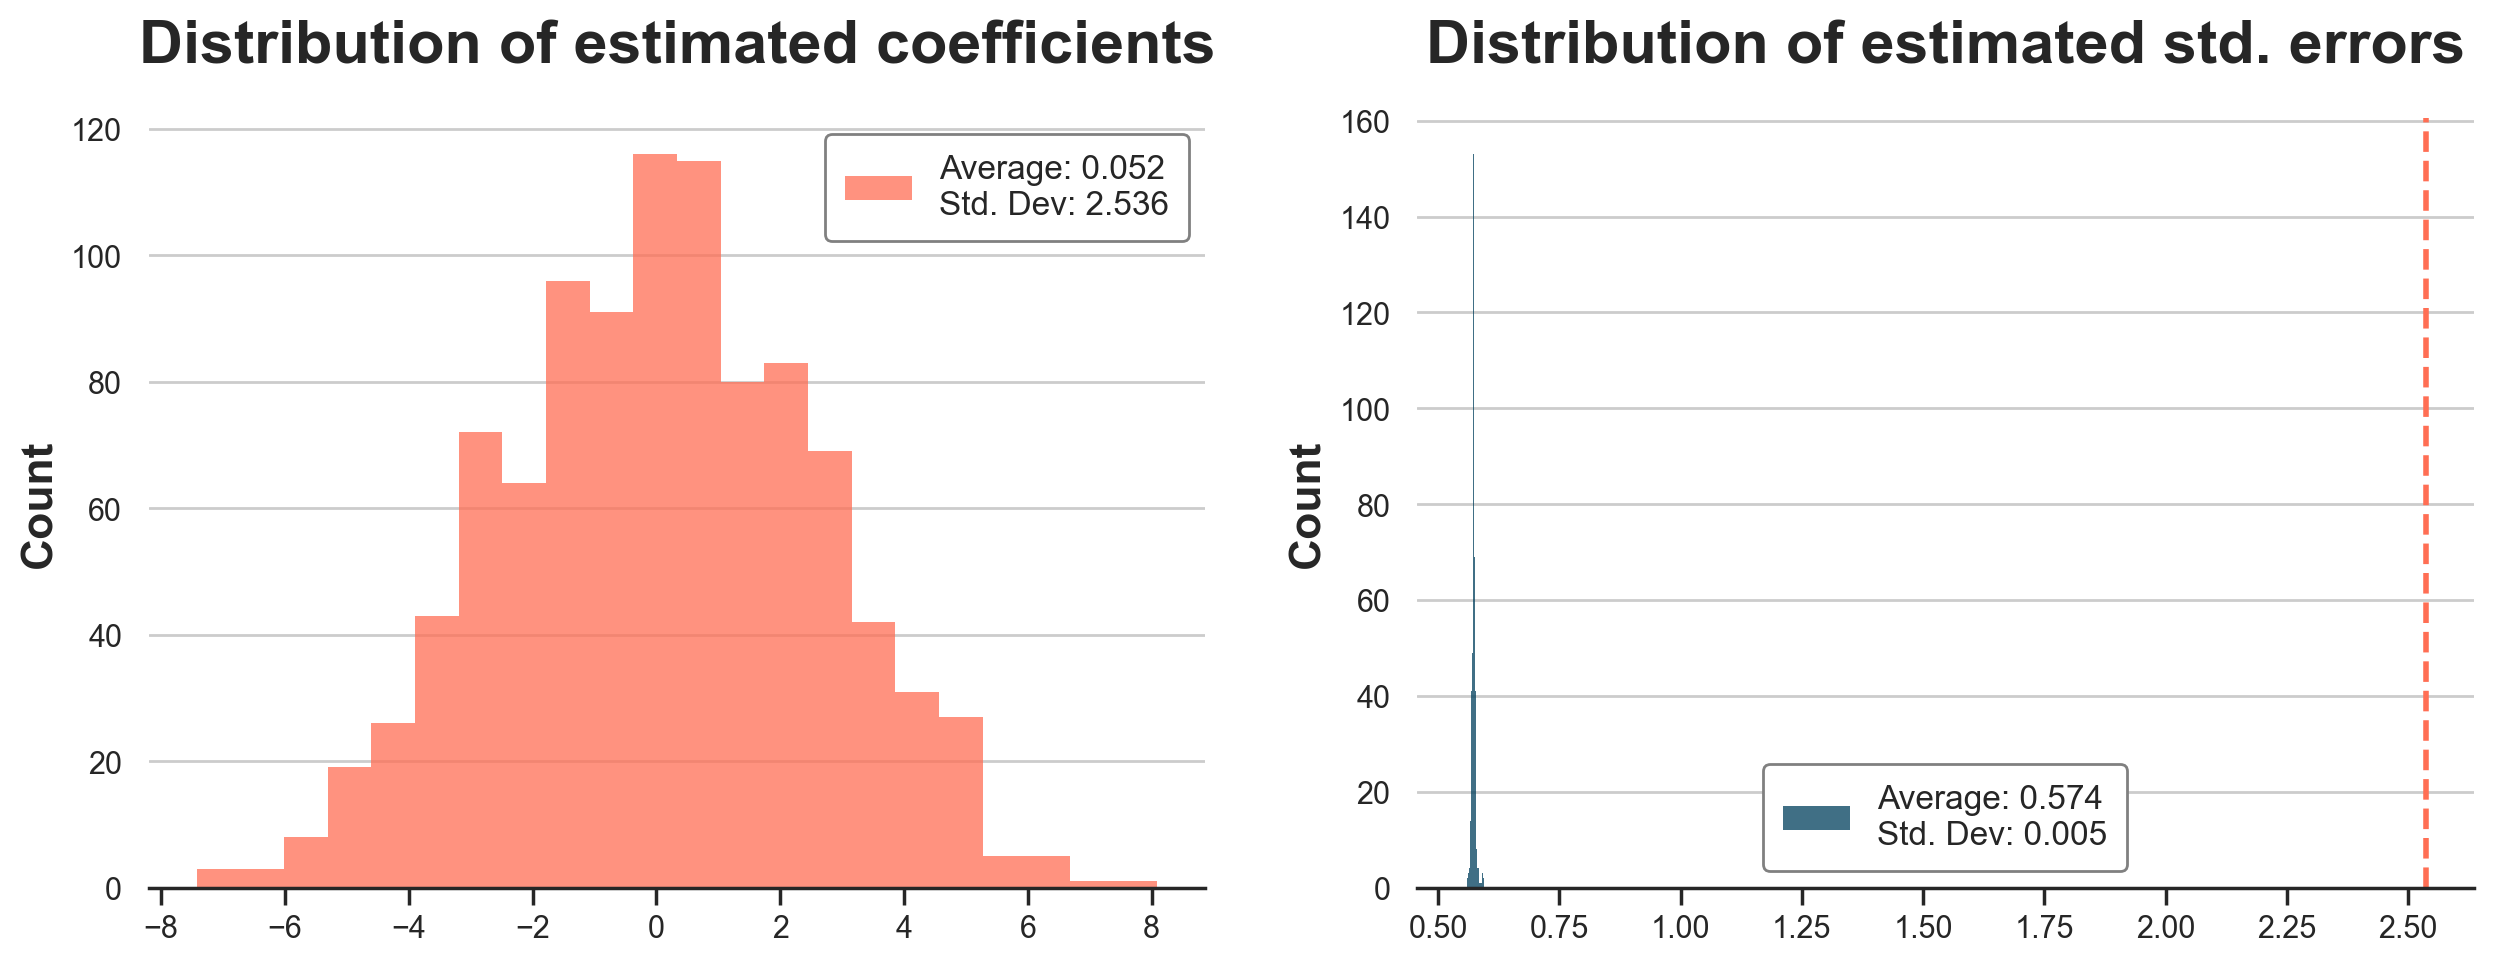

In [8]:
plot_coefficients(ols_coeff)

The average coefficient is very close to zero. Indeed, the true treatment effect is zero. However, the standard deviations of the estimated coefficients is  is *2.536*, fairly different from the estimated standard deviation of *0.576* we got from the linear regression table. This standard deviation would have implied a *p-value* of around *0.5*, extremely far from any statistical significance threshold. On the right panel, we see that this is not by chance: standard OLS consistently **underestimates** the variability of the coefficient by around 5 times. 

Could have we **detected** this issue in reality, without the possibility or re-randomizing the treatment assignment? Yes, by **bootstrapping** standard errors. If you never heard of bootstrapping, I wrote an article about it, and an interesting technique to make bootstrapping faster: the bayesian bootstrap.

https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148

Bootstrapping essentially consists in drawing **samples** of the data **with replacement**, and re-computing the target statistics across bootstrapped samples. We can then estimate its standard deviation by simply computing the standard deviation fo the statistics across samples.

In this case, it's important to sample the data **consistently** with the data generating process: by customer and not by order.

In [32]:
boot_estimates = []
customers = df.customer_id.unique()
for k in range(1000):
    np.random.seed(k)
    boot_customers = np.random.choice(customers, size=len(customers), replace=True)
    df_boot = pd.concat([df[df.customer_id == id] for id in boot_customers])
    reg = smf.ols("revenue ~ carousel", data=df_boot).fit()
    boot_estimates += [(reg.params["carousel"], reg.bse["carousel"])]

In the figure below, we plot the distribution of estimated coefficients and standard errors. The standard errors are still wrong, but the distribution of bootstrap estimates has a standard deviation of *2.465*, very close to the simulated value of *2.536*.

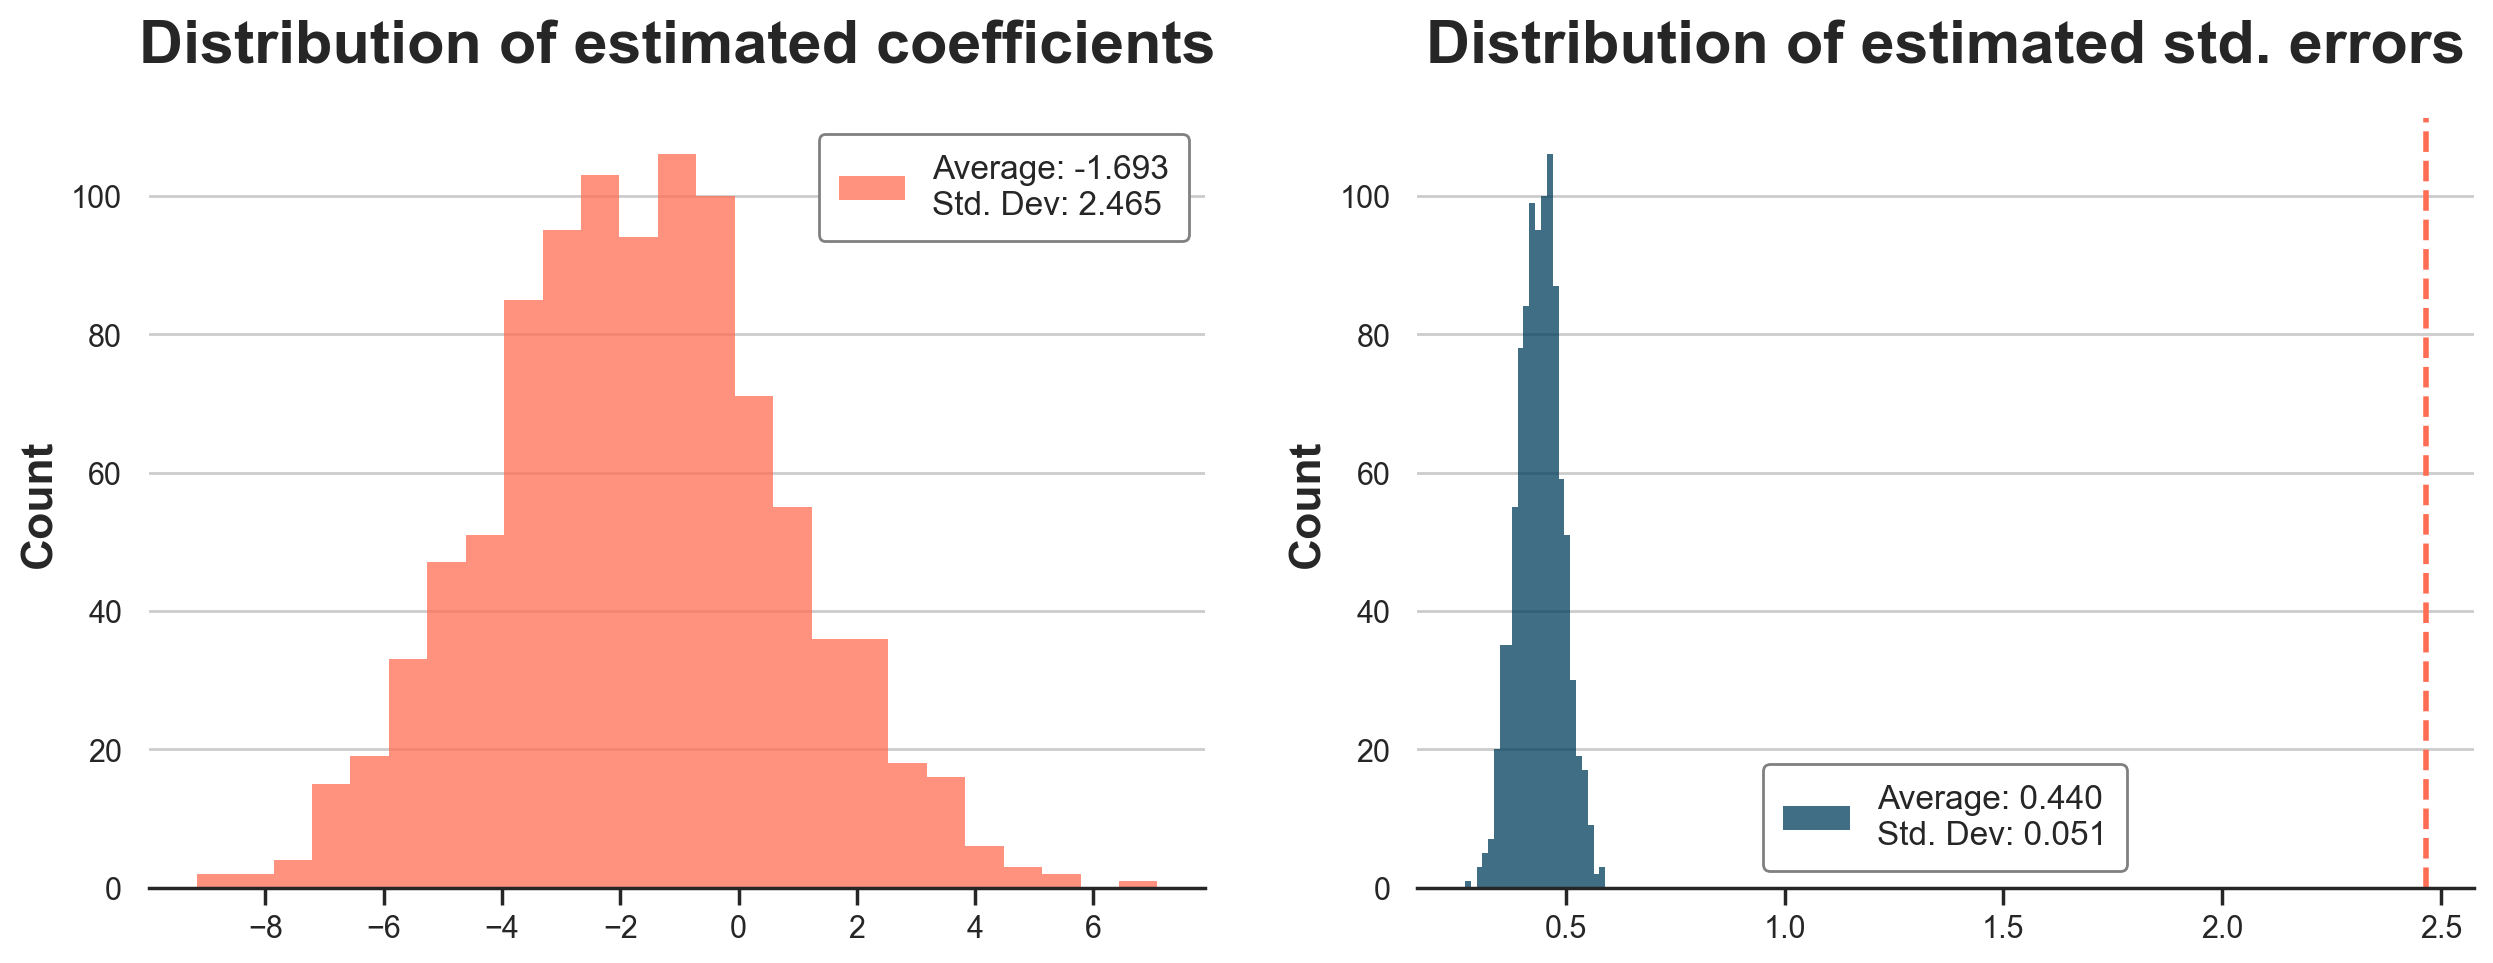

In [33]:
plot_coefficients(boot_estimates)

Note that in order to use bootstrapping to detect the issue in the linear regression standard errors, one would have needed to be *aware* that assignment was at the customer level. Bootstrapping the data at the order level would have still underestimated the standard errors.

## Clustered Standard Errors

What's the problem with the standard errors reported in the linear regression table?

The problem is that the usual formula to compute standard errors in linear regression (more on the math later) assumes that observations are independent and identically distributed, i.i.d.. However, in our case, the **independence** assumption is **not satisfied**. Why? 

In our example, the unit of treatment assignment, a `customer` is different from the unit of observation, an `order`. This is a problem because under different treatment assignments, all orders of a certain customer are either treated or not. They move in blocks and it cannot happen that two orders of the same customer are split across control and treatment group. The consequence of orders "moving in blocks" is that there is more variability in our estimates than we might have if orders were moving independently. Intuitively, there is less *balance* between the two groups, on average. As a consequence, standard errors computed assuming independence typically **underestimate** the actual variability of the estimator.

Is there a solution? Yes!

The solution is to use the so-called [cluster-robust standard errors](https://en.wikipedia.org/wiki/Clustered_standard_errors) that allow observations to be correlated within a cluster of observations, a `customer` in our case. Cluster-robust standard errors are usually very simple to implement and available in all statistical packages. With `statsmodels` we have to specify that the covariance type is `cluster` and that the groups are by `customer`.

In [11]:
smf.ols("revenue ~ carousel", data=df).fit(cov_type='cluster', cov_kwds={'groups': df["customer_id"]}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,61.6361,1.639,37.606,0.000,58.424,64.848
carousel,-1.6292,2.471,-0.659,0.510,-6.473,3.214


The estimated cluster-robust standard error is equal to `2.471`, extremely close to the simulated standard error of `2.536`. Note that the estimated coefficient has not changed (`-1.6292` as before).

How do cluster-robust standard errors work? We dig deeper in the math in the next section.

## Some Math

The general formula of the variance of the OLS estimator is
$$
\text{Var}(\hat \beta) = (X'X)^{-1} X' \epsilon \epsilon' X (X'X)^{-1}
$$

where *X* are the regression covariates, and *ε* are the residuals. The **key component** of this formula is the central matrix *n × n* matrix *Ω = ε ε'*, where *n* is the number of observations. It is key because it is the only object that we need to estimate in order to compute the variance of the OLS estimator. 

At first, it could be very tempting to just estimate *Ω* using the regression residuals *e = y - ŷ*, where *y* is the vector of outcomes, and *ŷ* are the regression predictions. However, the problem is that by construction the product of *X* and *e* is zero, and therefore the estimated variance would be zero

In [16]:
X.T @ e

array([[5.72555336e-11],
       [6.68904931e-11]])

The most simplifying assumption is called [**homoscedasticity**](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity): regression residuals are independent of each other and they all have the same variance. In practice, homoscedasticity implies that the *Ω* matrix is that it is diagonal with the same number in each cell:
$$
\Omega = 
\begin{bmatrix}
\sigma^2 & 0 & \dots & 0 & 0 \newline
0 & \sigma^2 & \dots & 0 & 0 \newline
\vdots & & \ddots &  & \vdots \newline
0 & 0 & ... & \sigma^2 & 0 \newline
0 & 0 & ... & 0 & \sigma^2 \newline
\end{bmatrix} = \sigma^2 I_n
$$

where *Iₙ* is the [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) of dimension *n*.

Under homoscedasticity, the residual matrix simplifies to 
$$
\text{Var}(\hat \beta) = (X'X)^{-1} X' \sigma^2 I_n X (X'X)^{-1} = \sigma^2 (X'X)^{-1} X' X (X'X)^{-1} = \sigma^2 (X'X)^{-1}
$$

and it's estimated by plugging-in the variance of the residuals

In [39]:
y_hat = X @ inv(X.T @ X) @ (X.T @ y)
e = y - y_hat
np.var(e)

245.20230307247473

So the estimated variance of the OLS estimator is given by
$$
\hat{\text{Var}}(\hat \beta) = \text{Var}(\hat \epsilon) (X'X)^{-1}
$$

In [18]:
np.var(e) * inv(X.T @ X)

array([[ 0.14595375, -0.14595375],
       [-0.14595375,  0.33171307]])

And the estimated standard error is just the squared root of the bottom-right value.

In [40]:
np.sqrt(np.var(e) * inv(X.T @ X))[1,1]

0.5759453727032665

The computed standard error is indeed the same that was reported before in the linear regression table, `0.576`. 

Homoscedasticity is a very restrictive assumption and it is always relaxed, allowing residual variances to be independent of each other. This assumption is called **heteroscedasticity**. 

$$
\Omega = 
\begin{bmatrix}
\sigma^2_1 & 0 & \dots & 0 & 0 \newline
0 & \sigma^2_2 & \dots & 0 & 0 \newline
\vdots & & \ddots &  & \vdots \newline
0 & 0 & ... & \sigma^2_{n-1} & 0 \newline
0 & 0 & ... & 0 & \sigma^2_n \newline
\end{bmatrix}
$$

Under heteroscedasticity the formula of the variance of the OLS estimator does not simplify anymore.

In [43]:
Sigma = np.eye(len(df)) * (e @ e.T)
np.sqrt(inv(X.T @ X) @ X.T @ Sigma @ X @ inv(X.T @ X))[1,1]

0.5757989320663413

In our case, the estimated standard error under heteroskedasticity is virtually the same: `0.576`.

In certain scenarios, even the heteroscedasticity assumption can be too restrictive, in case observations are correlated and regression residuals are not independent. In that case, we might want to allow certain off-diagonal elements of the *Ω* matrix to be different from zero. But which ones?

In many settings, including our example, it is reasonable to assume that observations are correlated within cluster, but with the same within-cluster variance. For example, if clusters are couples of observations, the *Ω* matrix takes the following form.
$$
\Omega = 
\begin{bmatrix}
\epsilon_1^2 & \epsilon_1 \epsilon_2 & 0 & 0 & \dots & 0 & 0 \newline
\epsilon_1 \epsilon_2 & \epsilon_2^2 & 0 & 0 & & 0 & 0 \newline
0 & 0 & \epsilon_3^2 & \sigma^2_{34} & & 0 & 0 \newline
0 & 0 & \sigma^2_{34} & \epsilon_3^2 & & 0 & 0 \newline
\vdots & & & & \ddots &  & \vdots \newline
0 & 0 & 0 & 0 & ... & \epsilon_{n-1}^2 & \sigma^2_{n-1,n} \newline
0 & 0 & 0 & 0 & ... & \sigma^2_{n-1,n} & \epsilon_n^2 \newline
\end{bmatrix}
$$

We can now compute the estimated standard errors under cluster-robustness.

In [49]:
customer_id = df[["customer_id"]].values
Sigma = (customer_id == customer_id.T) * (e @ e.T)
np.sqrt(inv(X.T @ X) @ X.T @ Sigma @ X @ inv(X.T @ X))[1,1]

2.458350214507729

We get indeed the same number reported in the linear regression table. But what's the **intuition** behind this formula?

## Intuition

To get an intuition for the estimated standard erorrs, imagine that we had a simple regression model with a single covariate: a constant. In that case, the estimated cluster-robust variance of the OLS estimator is just the sum of all the cross-products of residuals within each cluster.
$$
\hat{\text{Var}}(\hat{\beta}) = \sum_{g=1}^G \sum_{i=1}^{n_g} \sum_{j=1}^{n_g} \epsilon_i, \epsilon_j
$$

where *g* indexes clusters, and *ng* is the number of observations within cluster *g*. If observations are **independent**, the expected value of the product of the residuals of different observations is zero *𝔼[εᵢεⱼ]=0* and the estimated variance will be close to the sum of the squared residuals.
$$
\hat{\text{Var}}(\hat{\beta}) = \sum_{i} \epsilon_i^2
$$

At the other extreme instead, if observations are **extremely correlated**, the residuals in the same clusters will be very similar, and the estimated variance will be close to the sum of all the cross-products, for each cluster.
$$
\hat{\text{Var}}(\hat{\beta}) = \sum_{g} n_g^2 \epsilon_g^2
$$

Note that this is exactly the estimated variance you would have obtained by running the analysis as the cluster level, in our case aggregating the orders at the customer level. 

This means that, in practice, if your unit of assignment is different from the unit of observations, your **effective sample size** will be somewhere in between your actual sample size, and the number of clusters (customers in our example). In other words, you have less observations than the rows in your data. Whether you are closer to one extreme or the other it depends on the degree of *between-clusters* correlation relative to the *within-cluster* correlation of the residuals.

We can now **verify** this intuition using our data-generating process. Let's first scale down the *within-cluster* variance of the residuals to zero. 

In [20]:
dgp = dgp_carousel(n=n, w="carousel", y=["revenue"])
dgp.revenue_per_customer_std = 0
df = dgp.generate_data()

Now unadjusted and clustered standard errors should be the same, and they are indeed fairly close.

In [21]:
smf.ols("revenue ~ carousel", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,50.1235,0.243,206.431,0.000,49.647,50.600
carousel,0.0525,0.366,0.144,0.886,-0.665,0.770


In [22]:
smf.ols("revenue ~ carousel", data=df).fit(cov_type='cluster', cov_kwds={'groups': df["customer_id"]}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,50.1235,0.189,264.655,0.000,49.752,50.495
carousel,0.0525,0.343,0.153,0.878,-0.620,0.725


Now let's scale the cross-cluster variance to zero.

In [50]:
dgp = dgp_carousel(n=n, w="carousel", y=["revenue"])
dgp.revenue_std = 0
df = dgp.generate_data()

In this case, all the variance is at the cluster level, hence the difference between standard and clustered standard errors will be even more stark.

In [51]:
smf.ols("revenue ~ carousel", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,61.5123,0.295,208.376,0.000,60.934,62.091
carousel,-1.6812,0.445,-3.778,0.000,-2.554,-0.809


In [52]:
smf.ols("revenue ~ carousel", data=df).fit(cov_type='cluster', cov_kwds={'groups': df["customer_id"]}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,61.5123,1.671,36.806,0.000,58.237,64.788
carousel,-1.6812,2.430,-0.692,0.489,-6.444,3.081


## Conclusion

In this article, we have seen the importance of **cluster-robust standard errors** and when they are relevant in randomized experiments. If you assign treatment at a higher level than your unit of observation, this generates correlation across the treatment effects of your observations and computing standard errors using the usual formula that assumes independence usually underestimates the true variance of the estimator. We explore two solutions: cluster-robust standard errors and bootstrapped standard errors at the unit of assignment. 

A third conservative solution is to **aggregate the data** at the unit of observation. This would give conservative estimates of the standard errors, in presence of additional non-linear covariates. We would also need to use regression weights if we have different number of observations per cluster.

An important advantage of cluster-robust standard errors is that they are larger that the usual standard errors only if there is indeed dependence across observations. As we have seen in the last section, if observations are only mildly correlated across clusters, the cluster-robust standard errors will be extremely similar.

## References

- A. Abadie, S. Athey, G. W. Imbens, J. M. Wooldridge (2023), [When Should You Adjust Standard Errors for Clustering?](https://academic.oup.com/qje/article/138/1/1/6750017).

### Related Articles

- [The Bayesian Bootstrap](https://towardsdatascience.com/6ca4a1d45148)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/clustering.ipynb